In [1]:
# Tried for python 3.12.0 older versions might work as well
import climnet.community_detection.graph_tool.gt_functions as gtf
import climnet.community_detection.graph_tool.es_graph_tool as egt
import geoutils.utils.file_utils as fut
import geoutils.tsa.event_synchronization as es
import numpy as np
import xarray as xr
import geoutils.preprocessing.open_nc_file as of
import geoutils.plotting.plots as gplt
import geoutils.utils.time_utils as tu
import geoutils.geodata.base_dataset as bds
import geoutils.utils.spatial_utils as sput
import geoutils.utils.general_utils as gut
import geoutils.plotting.plots as gplt
import geoutils.preprocessing.open_nc_file as of
import climnet.network.clim_networkx as nx
import climnet.datasets.evs_dataset as evs

from importlib import reload


plot_dir = "/home/strnad/data/plots/extremes/"
data_dir = "/home/strnad/data/"

In [3]:
# Load the data
reload(of)
pr_file_path = f"{data_dir}/climate_data/1/mswep_pr_{1}_ds.nc"
ds_pr = of.open_nc_file(pr_file_path)
variable = 'pr'
da_pr = ds_pr[variable]
start_date, end_date = tu.get_start_end_date(da_pr)

Total size of '/home/strnad/data//climate_data/1/mswep_pr_1_ds.nc':
   3.70 GB bytes


['/home/strnad/data//climate_data/1/mswep_pr_1_ds.nc']
Check dimensions of dataset!
Checked labelling according to netcdf conventions!
Sorted longitudes and latitudes in ascending order!
Set time to np.datetime[ns] time format!
End processing data! Dimensions: ['time', 'lat', 'lon']


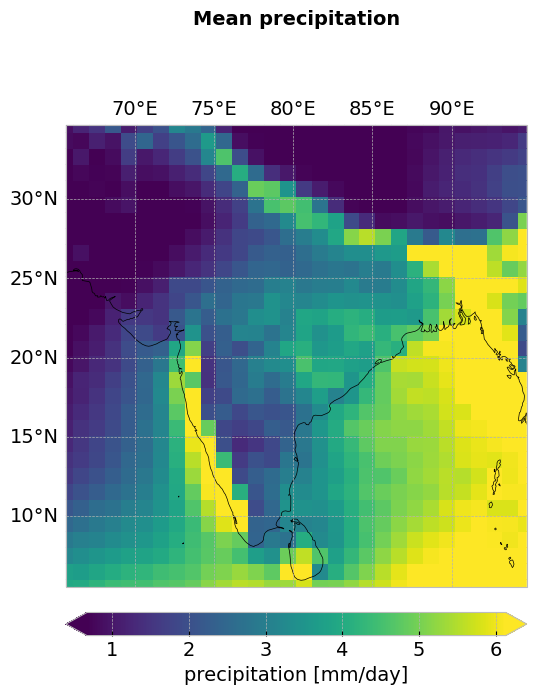

In [4]:
# Restrict to Indian subcontinent
lon_range = [65, 95]
lat_range = [5, 35]

da_india = sput.cut_map(da_pr, lon_range, lat_range)

mean_pr = da_india.mean(dim=["time"])
im = gplt.plot_map(mean_pr, title="Mean precipitation",
                   label="precipitation [mm/day]")

In [5]:
dates = tu.get_dates_of_time_range(time_range=[start_date,
                                   end_date], freq="D")

start_month = 'Jun'
end_month = 'Sep'
ds_india_month_range = tu.get_month_range_data(
    da_india, start_month, end_month,
    set_zero=True,)
dates_in_range = tu.get_month_range_data(dates, start_month, end_month)

/home/strnad/projects/geoutils/geoutils/utils/general_utils.py:824: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  def create_xr_ds(data, dims, coords, name=None):
/home/strnad/projects/geoutils/geoutils/utils/general_utils.py:824: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

In [6]:
# Create event series dataset by threshold 0.9 and an ERE should have at least 10 mm/day and at least per cell should be minimum 10 events over the full period
reload(tu)
reload(gplt)
q = 0.9
th_eev = 15
min_num_events = 10

evs_india, mask = tu.compute_evs(dataarray=ds_india_month_range,
                                 q=q,
                                 min_num_events=min_num_events,
                                 th_eev=th_eev,
                                 min_threshold=1  # This is important for the EREs
                                 )
q_map = tu.get_q_val_map(dataarray=da_india, q=q)

num_eres = evs_india.sum(dim='time')

Compute extreme events with quantile 0.9!
Fraction of events: 0.017914466392854815!
Fraction of masked values: 0.08!


WARNING! Set global map!
WARNING! Set global map!


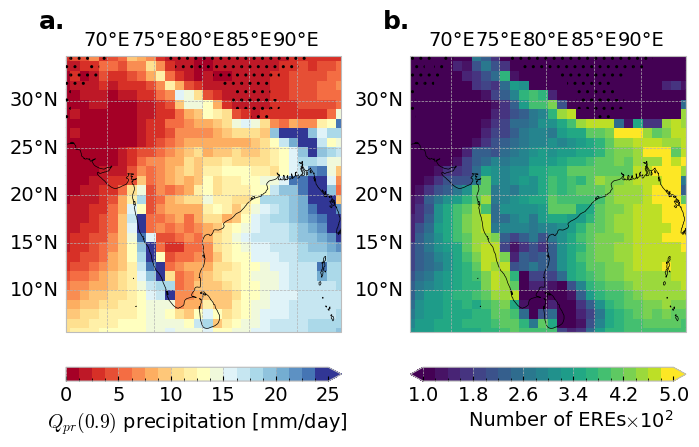

In [7]:
# Plot the data to get some idea about the number of EREs
fdic = gplt.create_multi_plot(
    1, 2,
    figsize=(8, 8),
    wspace=0.25,
    projection="PlateCarree")
gplt.plot_map(
    q_map,
    ax=fdic["ax"][0],
    significance_mask=xr.where(mask, 0, 1),
    plot_type="colormesh",
    label=rf"$Q_{{pr}}({{{q}}})$ precipitation [mm/day]",
    vmin=0, vmax=25, levels=20, tick_step=4,
    cmap="RdYlBu",
)

_ = gplt.plot_map(
    num_eres,
    ax=fdic["ax"][1],
    significance_mask=xr.where(mask, 0, 1),
    plot_type="colormesh",
    label=rf"Number of EREs",
    vmin=100, vmax=500, levels=20, tick_step=4,
    cmap="viridis",
)

In [8]:
# Create the network of EREs
reload(es)

# First create the null model (is only needed once for a particular length of the time points)
# Attention events per month are not uniform distributed
length = len(dates_in_range)
num_permutations = 1000
num_eres_month_range = evs_india.sum(dim='time')
max_num_events = int(np.max(num_eres_month_range))

savepath_null_model = f'null_models/null_model_{length}_{
    max_num_events}_{num_permutations}.npy'

In [9]:
reload(es)
if fut.exist_file(savepath_null_model):
    null_model_dict = fut.load_np_dict(savepath_null_model)
else:
    null_model_dict = es.null_model_distribution(
        length_time_series=length,
        max_num_events=max_num_events*0.8,
        num_permutations=num_permutations,
        savepath=savepath_null_model,
    )
    fut.save_np_dict(null_model_dict,
                     savepath_null_model)

Load...
Total size of 'null_models/null_model_5124_508_1000.npy':
   16.06 MB bytes


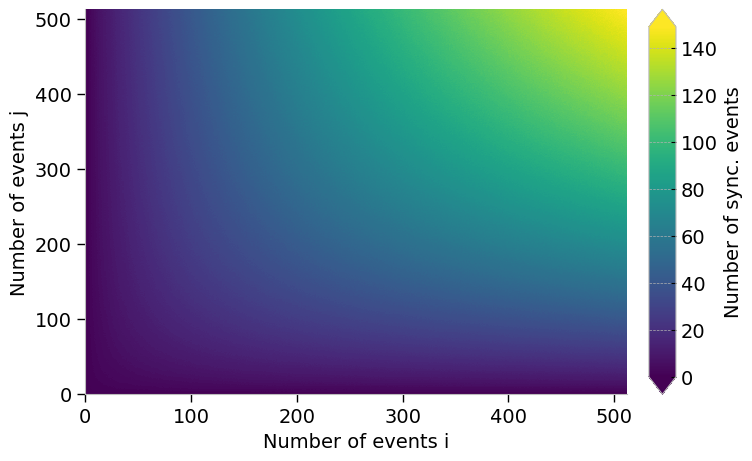

In [10]:
# Plot the null model
reload(gplt)
im = gplt.plot_array(z=null_model_dict[0.95],
                     label='Number of sync. events',
                     xlabel='Number of events i',
                     ylabel='Number of events j',
                     orientation='vertical',)



In [11]:
# First prepare the data to a dataset with numbers per cell to be better traceable in the network setting
reload(evs)
grid_type = 'fekete'
grid_step = 1
sp_grid = f'{grid_type}_{grid_step}.npy'
ds_evs = evs.EvsDataset(
    data=evs_india,
    grid_type=grid_type,
    sp_grid=sp_grid,
)

Set variable name to evs!
Start create grid fekete...
Try to load grid fekete_1.npy...
Load...
Total size of '/home/strnad/projects/climnet/climnet/grid/grids//fekete_1.npy':
   590.76 KB bytes
Loaded grid /home/strnad/projects/climnet/climnet/grid/grids//fekete_1.npy!
grid in range lat: [6, 35] and lon: [66, 95]


Intpo100%|██████████████████████████████| 15339/15339 [00:19<00:00, 781.32it/s]

Init spatial mask for shape: (15339, 711)


... Finished Initialization spatial mask
Init the point-idx dictionaries
Evs datat is stored in dataset.
Init spatial evs-mask for EVS data of shape: (711, 15339)
... Finished Initialization EVS-spatial mask
Init the point-idx dictionaries


In [12]:
# Init the network
reload(nx)
taumax = 10
Net = nx.Clim_NetworkX(dataset=ds_evs,
                       taumax=taumax,
                       )

# Run the event synchronization algorithm to all points of the network
Net.create(
    method='es',
    null_model_file=savepath_null_model,
    E_matrix_folder='./E_matrix/',
    q_sig=0.95,  # significance level of null model
)

Create Network based on method es
Load null model: .//null_models/null_model_5124_508_1000.npy
Not running with SLURM job arrays, but with 0
Computed Event Series Matrix
Store E-matrix as file E_matrix_evs_fekete_1_q_0.95_min_num_events_1_taumax_10_jobid_0.npy!
JobID 0: Start comparing all time series with taumax=10!
Start computing event synchronization for event data from 0 to 668!
Use 16 CPUs in parallel!


100%|██████████| 667/667 [06:12<00:00,  1.79it/s]


Now store results in numpy array to ./E_matrix/E_matrix_evs_fekete_1_q_0.95_min_num_events_1_taumax_10_jobid_0.npy!


100%|██████████| 667/667 [00:00<00:00, 3722.91it/s]

393.8991138935089
Store to ./E_matrix/E_matrix_evs_fekete_1_q_0.95_min_num_events_1_taumax_10_jobid_0.npy


Total size of './E_matrix/E_matrix_evs_fekete_1_q_0.95_min_num_events_1_taumax_10_jobid_0.npy':
   7.09 MB bytes
Finished for job ID 0
Last job (id: 0) finished. Now computing full E-matrix!


  0%|          | 0/2 [00:00<?, ?it/s]

Read Matrix with name ./E_matrix/E_matrix_evs_fekete_1_q_0.95_min_num_events_1_taumax_10_jobid_0.npy


 50%|█████     | 1/2 [00:00<00:00,  2.23it/s]

Read Matrix with name ./E_matrix/E_matrix_evs_q_0.95_min_num_events_1_taumax_10_jobid_0.npy


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

Finished computing Adjency Matrix for Null model with 667 time series!
Sparsity of adjacency:0.1748166396561839
Init the network by adjacency matrix (667, 667)
Set dataset attributes to network....



100%|██████████| 667/667 [00:00<00:00, 2290.20it/s]


No isolated nodes!
Re-Init the new network
Init the network by adjacency matrix (667, 667)
Set dataset attributes to network....


100%|██████████| 667/667 [00:00<00:00, 2583.72it/s]


Network Info: {'Num_nodes': 667, 'Num_edges': 77774, 'sparsity': 0.1748166396561839, 'Node_attrs': ['lon', 'lat'], 'Edge_attrs': ['weight']}


number of edges: 139
Saving figure to /home/strnad/data/plots/extremes//network_plots/india_[75, 80]_links.png


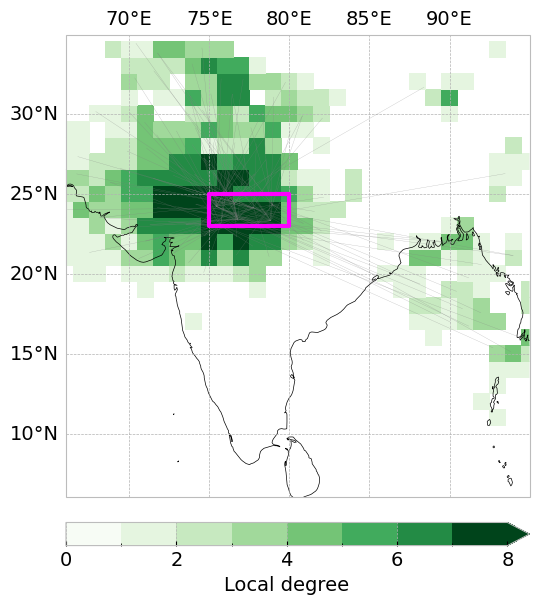

In [13]:
# plot links of the network
# Plot the network links for a certain location
reload(gplt)
lat_range = [23, 25]
lon_range = [75, 80]
link_dict = Net.get_edges_nodes_for_region(
    lon_range=lon_range, lat_range=lat_range, binary=False
)

# Plot nodes where edges go to
im = gplt.plot_map(
    link_dict['target_map'],
    ds=Net.ds,
    label=f"Local degree",
    projection="PlateCarree",
    plot_type="colormesh",
    cmap="Greens",
    vmin=0,
    vmax=8,
    levels=8,)

im = gplt.plot_edges(
    Net.ds,
    link_dict['el'][::5],  # plot every fifth edge
    ax=im["ax"],
    lw=0.2,
    alpha=0.6,
)

gplt.plot_rectangle(
    ax=im["ax"],
    lon_range=lon_range,
    lat_range=lat_range,
    color="magenta",
    lw=3,
    zorder=11
)
savepath = f"{plot_dir}/network_plots/india_{lon_range}_links.png"
gplt.save_fig(savepath)

In [14]:
# Apply community detection to the network
reload(gtf)
reload(egt)
num_communities = 5
res_dict = gtf.apply_SBM(Net.cnx, B_max=num_communities,
                         multi_level=False)


Graph N 667, B 57752
Finished creating gt-graph! Summary:
<Graph object, directed, with 667 vertices and 57752 edges, at 0x7359e3fa5fa0>
Start computing SBM on graph...
Compute Blockmodel on single level...
Finished minimize 1 - level Blockmodel!
 Finished MCMC search! Improvement: 0.0
Sample from the posterior in 1000 samples!
Finished sampling from the posterior.
New number of groups: 5 < previous: 668
[[1 1 4 2 0 0 1 4 3 4 2 1 0 2 0 0 1 0 3 0 2 4 3 2 1 0 3 2 1 0 0 0 1 1 0 0
  3 4 1 4 0 0 1 4 0 1 3 4 1 2 3 1 2 3 0 1 3 1 0 4 4 4 3 3 2 1 1 1 1 1 3 2
  1 1 0 4 0 0 1 2 4 2 4 1 2 0 4 1 3 2 1 0 1 1 3 4 2 3 4 2 4 3 4 0 2 0 0 0
  4 4 3 1 3 0 1 4 2 2 0 1 1 1 2 1 0 1 4 2 0 1 0 0 4 2 3 1 1 2 1 4 2 2 1 2
  0 4 3 4 1 1 4 2 1 2 1 4 4 2 2 0 3 1 4 0 0 1 0 3 0 1 4 3 2 0 0 1 0 2 4 1
  3 0 3 1 2 0 3 4 1 1 0 0 1 3 2 2 0 2 3 2 3 0 1 2 1 1 1 1 1 1 3 0 3 2 3 2
  0 1 0 0 0 1 0 4 0 1 0 3 2 4 1 3 0 0 0 2 3 4 1 1 2 0 1 0 4 4 2 0 0 0 2 4
  0 2 0 1 1 3 2 2 2 1 2 1 0 1 1 1 3 2 1 0 0 0 4 3 1 0 1 0 2 2 1 1 2 1 1 3


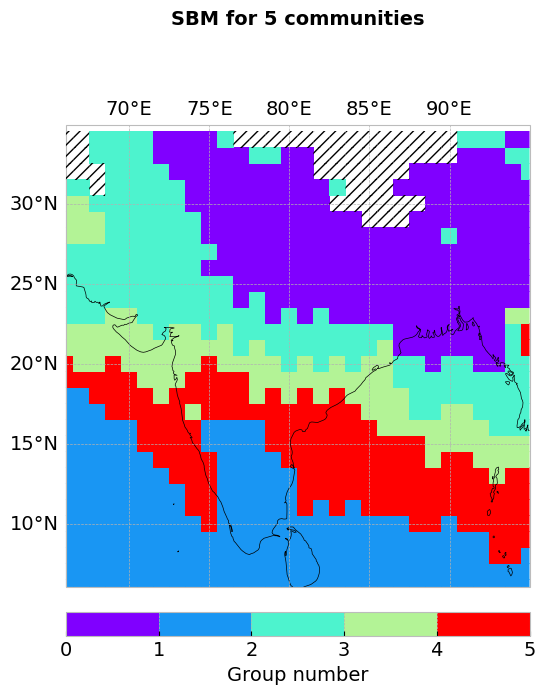

In [15]:
# plot the communities
reload(gplt)
hard_cluster = res_dict['group_levels'][0]  # theta['node_levels'][0]
hc_map = Net.ds.get_map(hard_cluster)
im = gplt.plot_map(
    hc_map,
    ds=Net.ds,
    vmin=0, vmax=num_communities,
    levels=num_communities,
    title=f'SBM for {num_communities} communities',
    significance_mask=True,
    plot_type="colormesh",
    projection="PlateCarree",
    cmap="rainbow",
    label="Group number",
    tick_step=1,
)
